Loading Data...
Generating Technical Indicators...

Feature Engineering Complete. Final Shape: (1974, 13)
             close  etf_close        RSI  Target
date                                            
2010-01-08  21.085     159.00  64.914089  20.480
2010-01-11  20.480     160.21  62.528964  20.664
2010-01-12  20.664     157.16  63.589579  20.830
2010-01-13  20.830     158.03  60.653458  20.655
2010-01-14  20.655     161.45  59.092448  20.655


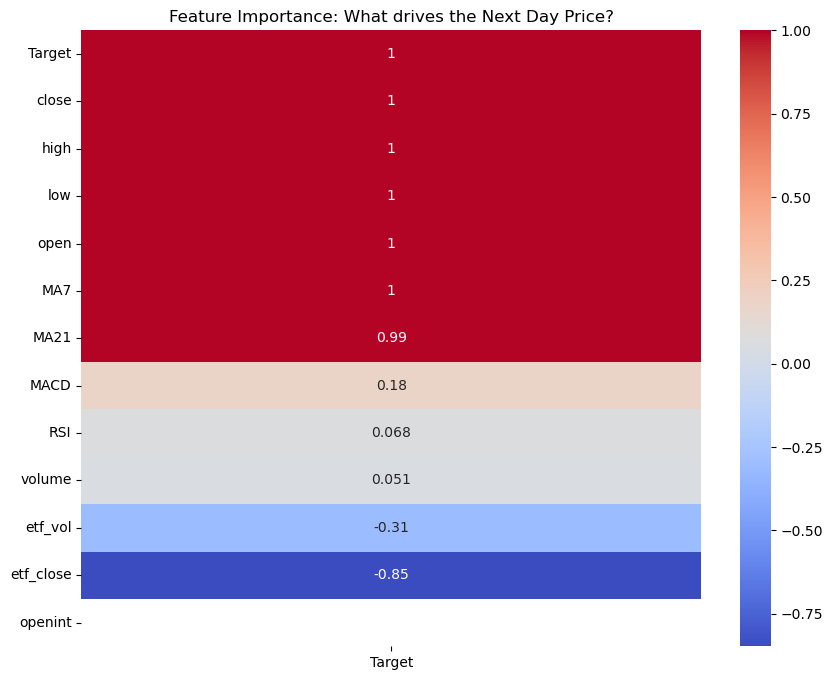

Saved processed data to 'processed_data.csv'


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
STOCK_NAME = 'iba'
ETF_NAME = 'pplt'  # The match we found in Step 2
DATA_PATH_STOCKS = '../data/Stocks'
DATA_PATH_ETFS = '../data/ETFs'

# --- HELPER FUNCTIONS ---
def load_data(path):
    df = pd.read_csv(path)
    df.columns = [c.lower() for c in df.columns]
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    return df

def calculate_rsi(data, window=14):
    """ Calculates Relative Strength Index (Technical Indicator) """
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# 1. Load Data
print("Loading Data...")
stock_df = load_data(f"{DATA_PATH_STOCKS}/{STOCK_NAME}.us.txt")
etf_df = load_data(f"{DATA_PATH_ETFS}/{ETF_NAME}.us.txt")

# 2. Merge Dataframes (The "Novel" Step)
# We rename ETF columns so we don't confuse them with Stock columns
etf_df = etf_df[['close', 'volume']].rename(columns={'close': 'etf_close', 'volume': 'etf_vol'})

# Left join ensures we keep all stock dates
df = stock_df.join(etf_df, how='left')

# Forward fill missing ETF data (if stock traded but ETF didn't)
df = df.ffill()

# 3. Feature Engineering (Adding Technical Indicators)
print("Generating Technical Indicators...")

# Moving Averages
df['MA7'] = df['close'].rolling(window=7).mean()
df['MA21'] = df['close'].rolling(window=21).mean()

# RSI (Relative Strength Index)
df['RSI'] = calculate_rsi(df['close'])

# MACD (Moving Average Convergence Divergence)
exp1 = df['close'].ewm(span=12, adjust=False).mean()
exp2 = df['close'].ewm(span=26, adjust=False).mean()
df['MACD'] = exp1 - exp2

# 4. Create the "Target"
# We want to predict the Close price of the NEXT day
df['Target'] = df['close'].shift(-1)

# Drop NaNs created by rolling windows and shifting
df.dropna(inplace=True)

print(f"\nFeature Engineering Complete. Final Shape: {df.shape}")
print(df[['close', 'etf_close', 'RSI', 'Target']].head())

# 5. Visualization of Feature Correlations
import seaborn as sns
plt.figure(figsize=(10, 8))
# Check correlation of our new features with the Target
sns.heatmap(df.corr()[['Target']].sort_values(by='Target', ascending=False), 
            annot=True, cmap='coolwarm')
plt.title("Feature Importance: What drives the Next Day Price?")
plt.show()

# 6. Save for Modeling
df.to_csv('processed_data.csv')
print("Saved processed data to 'processed_data.csv'")